# Jaffle Shop Data Analysis - Final Project

## Instructions
You have been hired as a data analyst for Jaffle Shop, a growing chain of gourmet toasted sandwich restaurants. The executive team needs insights to make strategic business decisions.

Using the provided datasets and Python Polars, analyze the business performance and provide data-driven recommendations. You must use Polars for all data manipulation and analysis.

## Available Data
- `Customers.csv`: Customer information
- `Orders.csv`: Order transactions with totals and timestamps
- `Items.csv`: Individual items within each order
- `Products.csv`: Product catalog with prices and descriptions
- `Stores.csv`: Store locations and opening dates
- `Supplies.csv`: Supply costs for each product

**Time Limit: 90 minutes**

## Setup and Data Loading

In [6]:
# Import necessary libraries
import polars as pl
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')

In [8]:
# Load all datasets

# load dataset using github path for customer data
customers = pl.read_csv('https://raw.githubusercontent.com/philhetzel/opan5510-finalproject/refs/heads/main/data/Customers.csv')
orders = pl.read_csv('https://raw.githubusercontent.com/philhetzel/opan5510-finalproject/refs/heads/main/data/Orders.csv')
items = pl.read_csv('https://raw.githubusercontent.com/philhetzel/opan5510-finalproject/refs/heads/main/data/Items.csv')
products = pl.read_csv('https://raw.githubusercontent.com/philhetzel/opan5510-finalproject/refs/heads/main/data/Products.csv')
stores = pl.read_csv('https://raw.githubusercontent.com/philhetzel/opan5510-finalproject/refs/heads/main/data/Stores.csv')
supplies = pl.read_csv('https://raw.githubusercontent.com/philhetzel/opan5510-finalproject/refs/heads/main/data/Supplies.csv')

# Display basic information about each dataset
print("Dataset shapes:")
print(f"Customers: {customers.shape}")

print(f"Orders: {orders.shape}")

print(f"Items: {items.shape}")

print(f"Products: {products.shape}")

print(f"Stores: {stores.shape}")

print(f"Supplies: {supplies.shape}")


Dataset shapes:
Customers: (932, 2)
Orders: (63148, 7)
Items: (90184, 3)
Products: (10, 5)
Stores: (6, 4)
Supplies: (65, 5)


## Question 1: Revenue Performance Analysis

The CFO wants to understand the company's financial performance across different dimensions. Analyze:
- What is the total revenue generated by Jaffle Shop? (Store result in variable: `total_revenue`)
- How does revenue vary by store location? (Store result in variable: `revenue_by_store`)
- What are the monthly revenue trends? (Store result in variable: `monthly_revenue_trends`)
- Which day of the week generates the most revenue? (Store result in variable: `revenue_by_day_of_week`)
- Include at least one chart for one of these questions

In [9]:
# Q1.1: Calculate total revenue
total_revenue = orders.select(pl.sum("order_total")).item()
print(f"Total Revenue: ${total_revenue:,.2f}")

Total Revenue: $66,038,193.00


In [10]:
# Q1.2: Revenue by store location
def format_currency_polars(value):
    return f"${value:,.2f}"

revenue_by_store = (
    orders
    .group_by("store_id")
    .agg(pl.col("order_total").sum().alias("total_revenue"))
    .join(stores.select(["id", "name"]), left_on="store_id", right_on="id", how="left")
    .sort("total_revenue", descending=True)
    .with_columns(
        pl.col("total_revenue").map_elements(format_currency_polars, return_dtype=pl.Utf8).alias("revenue_by_store")
    )
)

print("Revenue by Store Location:")
display(revenue_by_store.select(["name", "revenue_by_store"]).head(5))
print("It can be seen that there has been no orders in the stores : Chicago, San Francisco and New Orleans ")

Revenue by Store Location:


name,revenue_by_store
str,str
"""Philadelphia""","""$43,215,565.00"""
"""Brooklyn""","""$22,822,628.00"""


It can be seen that there has been no orders in the stores : Chicago, San Francisco and New Orleans 


In [11]:
# Q1.3: Monthly revenue trends

# Convert 'ordered_at' to datetime
orders_with_month = orders.with_columns(pl.col("ordered_at").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S").cast(pl.Date).alias("order_date"))

# Extract year and month, also adding the change in monthly revenue each month:
monthly_revenue_trends = (orders_with_month.group_by(pl.col("order_date").dt.year().alias("year"), pl.col("order_date").dt.month().alias("month"))
                          .agg(pl.sum("order_total").alias("monthly_revenue"))
                          .sort(["year", "month"])
                          .with_columns(pl.col("monthly_revenue").shift(1).alias("previous_monthly_revenue"))
                          .with_columns((pl.col("monthly_revenue") - pl.col("previous_monthly_revenue")).alias("monthly_revenue_change"))
                          .with_columns(
                              pl.col("monthly_revenue_change").map_elements(format_currency_polars, return_dtype=pl.Utf8).alias("monthly_revenue_difference")
                          )
)

print("Monthly Revenue Trends:")
display(
    monthly_revenue_trends.with_columns(
        pl.col("monthly_revenue").map_elements(format_currency_polars, return_dtype=pl.Utf8).alias("monthly_revenue"))
    .select(["year", "month", "monthly_revenue", "monthly_revenue_difference"]))

Monthly Revenue Trends:


year,month,monthly_revenue,monthly_revenue_difference
i32,i8,str,str
2016,9,"""$1,644,922.00""",null
2016,10,"""$1,956,651.00""","""$311,729.00"""
2016,11,"""$2,552,662.00""","""$596,011.00"""
2016,12,"""$3,307,337.00""","""$754,675.00"""
2017,1,"""$3,821,291.00""","""$513,954.00"""
…,…,…,…
2017,4,"""$7,392,014.00""","""$779,953.00"""
2017,5,"""$8,469,909.00""","""$1,077,895.00"""
2017,6,"""$8,617,148.00""","""$147,239.00"""


Revenue by Day of Week:


order_day_of_week,daily_revenue
str,i64
"""Monday""",10611971
"""Tuesday""",10814455
"""Wednesday""",10834569
"""Thursday""",10829195
"""Friday""",10758715
"""Saturday""",5981489
"""Sunday""",6207799


Highest revenue day: Wednesday with $10,834,569.00


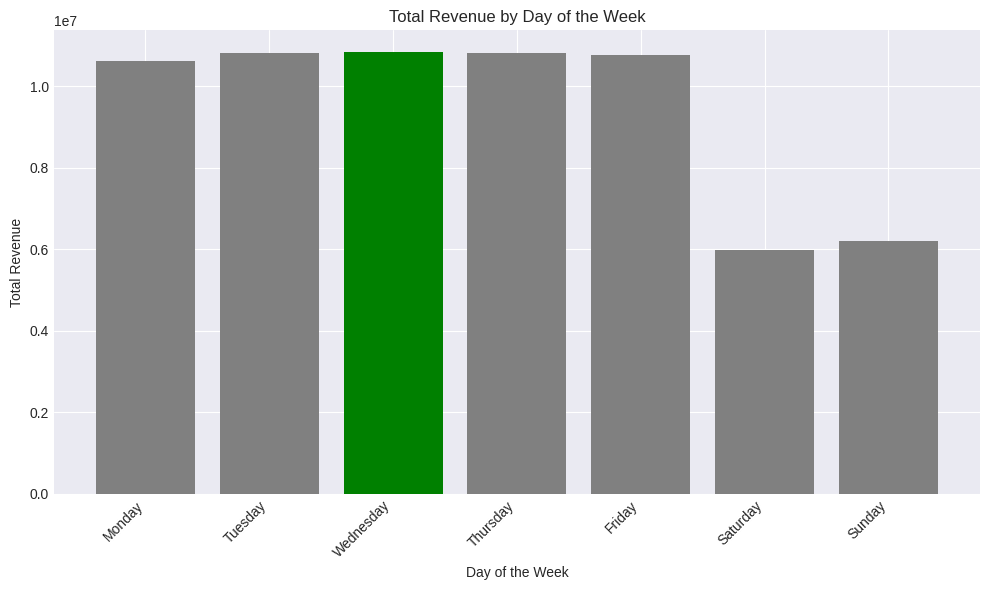

In [13]:
# Q1.4: Revenue by day of week
# Extract day of the week
revenue_by_day_of_week_table = orders_with_month.with_columns(
    pl.col("order_date").dt.weekday().alias("order_day_of_week_num") # Extract weekday number (Monday=1, Sunday=7)
).group_by("order_day_of_week_num").agg(pl.sum("order_total").alias("daily_revenue")).sort("order_day_of_week_num") # Sort by weekday number

# Map weekday numbers to names for display and plotting
weekday_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
revenue_by_day_of_week_table = revenue_by_day_of_week_table.with_columns(
    pl.col("order_day_of_week_num").map_elements(lambda x: weekday_names[x - 1], return_dtype=pl.Utf8).alias("order_day_of_week")
)

print("Revenue by Day of Week:")
display(revenue_by_day_of_week_table.select(["order_day_of_week", "daily_revenue"]))

#printing the max revenue of the week day
highest_revenue_day_row = revenue_by_day_of_week_table.sort("daily_revenue", descending=True).row(0)
highest_revenue_day_name = highest_revenue_day_row[2] # Get the day name
highest_revenue = highest_revenue_day_row[1] # Get the revenue value
print(f"Highest revenue day: {highest_revenue_day_name} with ${highest_revenue:,.2f}")


#plotting
weekdays = revenue_by_day_of_week_table['order_day_of_week'].to_list()
revenues = revenue_by_day_of_week_table['daily_revenue'].to_list()

highest_revenue_day_index = weekdays.index(highest_revenue_day_name)

colors = ["gray"] * len(revenues)
colors[highest_revenue_day_index] = "green"

plt.figure(figsize=(10, 6)) # Increase figure size for better readability
plt.bar(weekdays, revenues, color = colors)
plt.xlabel('Day of the Week')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by Day of the Week')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

## Question 2: Product Performance

The Product Manager needs insights about the menu items:
- What is the revenue contribution of each product category (jaffles vs beverages)? (Store result in variable: `revenue_by_category`)
- What is the average price of products by type (jaffles vs beverages)?
- Include at least one chart to answer one of the above questions.


Revenue contribution by product category:


type,total_revenue_$
str,str
"""beverage""","""$39,836,200.00"""
"""jaffle""","""$22,880,900.00"""


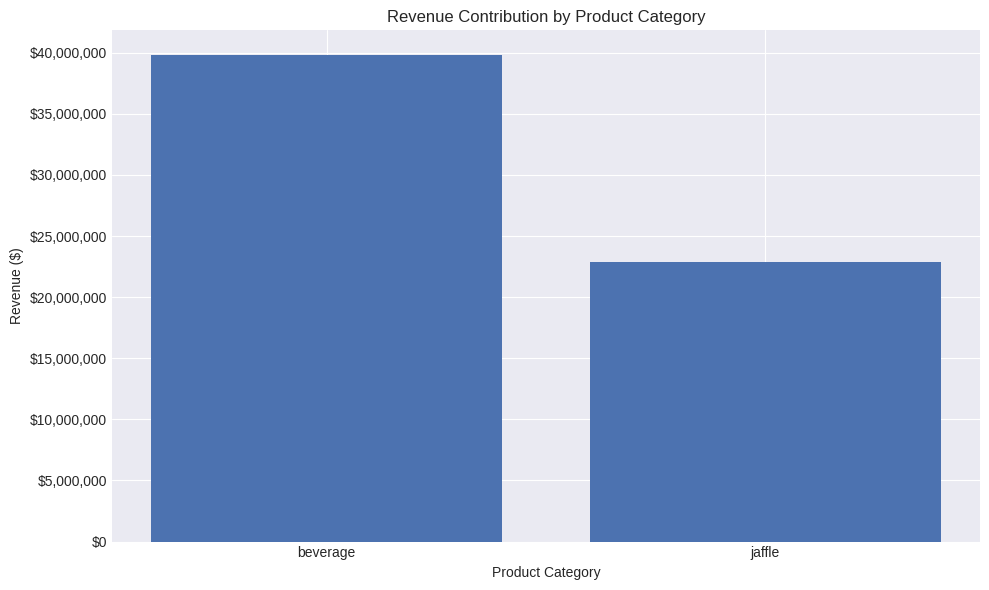

In [14]:
# Q2.1: Revenue by product category
# Your code here

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Join items with products to get type and price
items_with_price = items.join(products.select(["sku", "type", "price"]), on="sku")

# Group by product type and sum the price to get revenue contribution
revenue_by_category = (
    items_with_price.group_by("type")
    .agg(pl.sum("price").alias("total_revenue"))
    .sort("total_revenue", descending=True)
)

# Helper function to format as currency
def fmt_currency(x: float) -> str:
    return "${:,.2f}".format(x)

# Display the result nicely
print("\nRevenue contribution by product category:")
display(
    revenue_by_category.with_columns(
        pl.col("total_revenue").map_elements(fmt_currency, return_dtype=pl.Utf8)
        .alias("total_revenue_$")
    ).select(["type", "total_revenue_$"])
)

# --- Bar Chart ---
plt.figure(figsize=(10, 6))
plt.bar(revenue_by_category["type"], revenue_by_category["total_revenue"], color="#4C72B0")
plt.title("Revenue Contribution by Product Category")
plt.xlabel("Product Category")
plt.ylabel("Revenue ($)")
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.show()

In [15]:
# Q2.2 Average price of products by type
average_price_by_type = products.group_by("type").agg(pl.mean("price").alias("average_price"))

print("Average Product Price by Category:")
display(average_price_by_type)

Average Product Price by Category:


type,average_price
str,f64
"""beverage""",560.0
"""jaffle""",1200.0


## Question 3: Store Expansion Strategy

The Operations Director is planning expansion strategies:
- Which stores have the highest revenue per day since opening? (Store result in variable: `revenue_per_day_by_store`)
- What is the relationship between local tax rates and store performance? (Store result in variable: `tax_rate_performance`)
- Include at least one chart to answer one of the above questions.


Revenue per Day Since Opening by Store:


store_name,total_revenue_$,total_days_open,revenue_per_day_$
str,str,i64,str
"""Brooklyn""","""$22,822,628.00""",173,"""$131,922.71"""
"""Philadelphia""","""$43,215,565.00""",365,"""$118,398.81"""


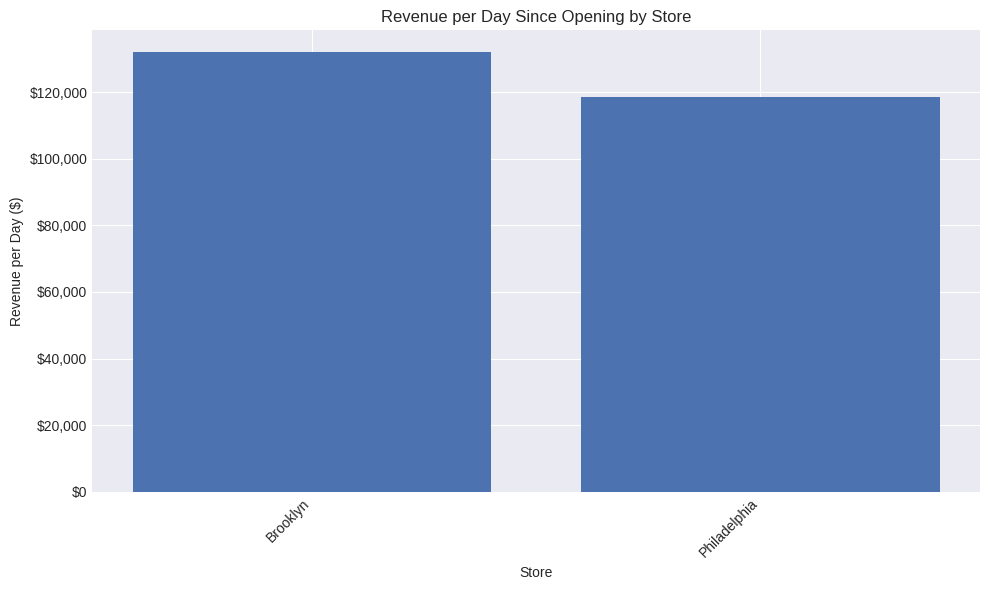

In [16]:
# Q3.1: Revenue per day since opening by store
# Your code here

import polars as pl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Helper function to format currency
def fmt_currency(x: float) -> str:
    return "${:,.2f}".format(x)

# Revenue per day since opening by store
revenue_per_day_by_store = (
    orders.join(stores.select(["id", "opened_at", "name"]), left_on="store_id", right_on="id")
    .with_columns([
        pl.col("ordered_at").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S").alias("ordered_at_dt"),
        pl.col("opened_at").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S").alias("opened_at_dt")
    ])
    .with_columns(
        ((pl.col("ordered_at_dt") - pl.col("opened_at_dt")).dt.total_days() + 1).alias("days_since_opening")
    )
    .group_by("store_id")
    .agg([
        pl.sum("order_total").alias("total_revenue"),
        pl.max("days_since_opening").alias("total_days_open"),
        pl.first("name").alias("store_name")
    ])
    .with_columns((pl.col("total_revenue") / pl.col("total_days_open")).alias("revenue_per_day"))
    .sort("revenue_per_day", descending=True)
)


print("\nRevenue per Day Since Opening by Store:")
display(
    revenue_per_day_by_store.with_columns([
        pl.col("total_revenue").map_elements(fmt_currency, return_dtype=pl.Utf8).alias("total_revenue_$"),
        pl.col("revenue_per_day").map_elements(fmt_currency, return_dtype=pl.Utf8).alias("revenue_per_day_$")
    ]).select(["store_name", "total_revenue_$", "total_days_open", "revenue_per_day_$"]) # Moved select to here
)

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(revenue_per_day_by_store["store_name"], revenue_per_day_by_store["revenue_per_day"], color="#4C72B0")
plt.title("Revenue per Day Since Opening by Store")
plt.xlabel("Store")
plt.ylabel("Revenue per Day ($)")
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.show()

In [17]:
# Q3.2: Tax rates vs store performance

tax_rate_performance = revenue_per_day_by_store.join(
    stores.select(["id", "tax_rate"]), left_on="store_id", right_on="id"
).with_columns(
    # divide instead of multiply
    (pl.col("revenue_per_day") / (1 + pl.col("tax_rate"))).alias("revenue_per_day_with_tax")
).select(
    ["store_name", "revenue_per_day", "tax_rate", "revenue_per_day_with_tax"]
).sort("tax_rate")


tax_rate_performance = tax_rate_performance.with_columns([
    pl.col("revenue_per_day").map_elements(fmt_currency, return_dtype=pl.Utf8).alias("revenue_per_day_$"),
    pl.format("{}%", (pl.col("tax_rate") * 100).round(2)).alias("tax_rate"),
    pl.col("revenue_per_day_with_tax").map_elements(fmt_currency, return_dtype=pl.Utf8).alias("revenue_per_day_with_tax_$")
])

print("\nTax Rate vs Store Performance (Tax Deducted Revenue per Day):")
display(
    tax_rate_performance.select("store_name", "revenue_per_day_$", "tax_rate", "revenue_per_day_with_tax_$")
)


Tax Rate vs Store Performance (Tax Deducted Revenue per Day):


store_name,revenue_per_day_$,tax_rate,revenue_per_day_with_tax_$
str,str,str,str
"""Brooklyn""","""$131,922.71""","""4.0%""","""$126,848.76"""
"""Philadelphia""","""$118,398.81""","""6.0%""","""$111,696.99"""


## Question 4: Customer Behavior Analysis

The Marketing Manager wants to understand customer patterns:
- What is the distribution of order values? (Store result in variable: `order_value_distribution`)
- How many customers are repeat customers? (Store result in variable: `repeat_customer_analysis`)
- Which customers contribute the most to revenue? (Store result in variable: `top_revenue_customers`)

Descriptive statistics for Order Total: shape: (8, 2)
┌───────────┬─────────────┐
│ statistic ┆ order_total │
│ ---       ┆ ---         │
│ str       ┆ f64         │
╞═══════════╪═════════════╡
│ count     ┆ 63148.0     │
│ mean      ┆ 1045.76856  │
│ std       ┆ 1025.930713 │
│ min       ┆ 0.0         │
│ 25%       ┆ 530.0       │
│ 50%       ┆ 636.0       │
│ 75%       ┆ 1165.0      │
│ max       ┆ 10281.0     │
└───────────┴─────────────┘


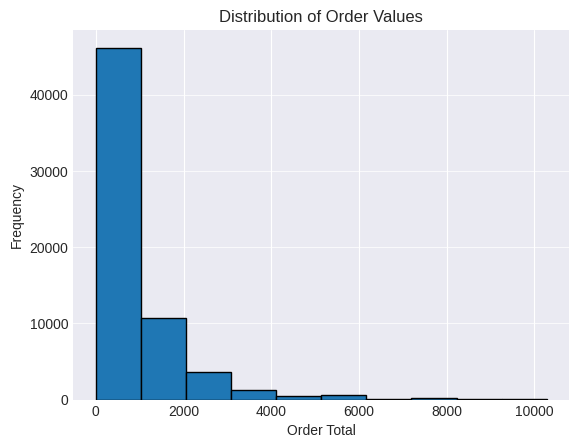

As seen from the histogram, as the order total increases the frequency of such orders decrease


In [18]:
# Q4.1: Distribution of order values
order_value_distribution = (orders.select(
    pl.col('order_total')).describe()
    ).filter(
        pl.col('statistic') != 'null_count'
    )
print("Descriptive statistics for Order Total:", order_value_distribution)

plt.hist(orders['order_total'], bins=10, edgecolor='black')
plt.xlabel('Order Total')
plt.ylabel('Frequency')
plt.title('Distribution of Order Values')
plt.grid(axis='y', alpha=0.75)
plt.show()

print("As seen from the histogram, as the order total increases the frequency of such orders decrease")

In [19]:
# Q4.2: Repeat customers analysis
# Group by customer and count orders
customer_order_counts = orders.group_by("customer").agg(pl.len().alias("order_count"))

# Identify repeat customers (more than 1 order)
repeat_customers = customer_order_counts.filter(pl.col("order_count") > 1)

# Count the number of repeat customers and total customers
num_repeat_customers = repeat_customers.shape[0]
num_total_customers = orders.select("customer").n_unique()

# Calculate the percentage of repeat customers
percentage_repeat_customers = (num_repeat_customers / num_total_customers) * 100 if num_total_customers > 0 else 0

repeat_customer_analysis = pl.DataFrame({
    "Total Customers": [num_total_customers],
    "Repeat Customers": [num_repeat_customers],
    "Percentage Repeat Customers": [percentage_repeat_customers]
})

print("Repeat Customer Analysis:")
display(repeat_customer_analysis)

Repeat Customer Analysis:


Total Customers,Repeat Customers,Percentage Repeat Customers
i64,i64,f64
930,920,98.924731


In [20]:
# Q4.3: Top revenue contributors
# Group by customer and sum order total
revenue_of_customers = orders.group_by("customer").agg(pl.sum("order_total").alias("total_spent")).sort("total_spent", descending=True)

top_revenue_customers = revenue_of_customers.join(
    customers.select(['id', 'name']),
    left_on='customer',
    right_on='id',
    how='left'
)
print("Top 10 customers contributing most to revenue:", top_revenue_customers.select(
    ['name','total_spent']).sort('total_spent', descending=True).head(10)
    )

Top 10 customers contributing most to revenue: shape: (10, 2)
┌──────────────────────┬─────────────┐
│ name                 ┆ total_spent │
│ ---                  ┆ ---         │
│ str                  ┆ i64         │
╞══════════════════════╪═════════════╡
│ David Leonard        ┆ 262647      │
│ Jesse Moore          ┆ 259037      │
│ Diane Davis          ┆ 258515      │
│ Holly Johnson        ┆ 252703      │
│ Gregory Hayes        ┆ 249821      │
│ Julie Robinson       ┆ 247510      │
│ Christopher Robinson ┆ 246325      │
│ Douglas Burgess      ┆ 244102      │
│ Jacob Brown          ┆ 239641      │
│ Jenny Harrell        ┆ 237098      │
└──────────────────────┴─────────────┘


## Question 5: Profitability Deep Dive

The CEO needs a comprehensive profitability analysis:
- Calculate the gross margin for each product (consider supply costs) (Store result in variable: `product_margins`)
- Which products have the highest profit margins? (Store result in variable: `highest_margin_products`)
- What is the relationship between order size and profitability? (Store result in variable: `order_size_profitability`)
- How does profitability vary across different stores? (Store result in variable: `store_profitability`)

In [45]:
# Q5.1: Calculate gross margin per product
product_sales = (

    items

    .join(products, left_on="sku", right_on="sku")

    .join(supplies, left_on="sku", right_on="sku")

    .with_columns([

        pl.col("price").alias("revenue_per_unit"),

        pl.col("cost").alias("cost_per_unit")

    ])

    .with_columns(

        (pl.col("revenue_per_unit") - pl.col("cost_per_unit")).alias("profit_per_unit")

    )

)



product_margins = (

    product_sales

    .group_by(["sku", "name"])

    .agg([

        pl.sum("revenue_per_unit").alias("total_revenue"),

        pl.sum("cost_per_unit").alias("total_cost"),

        pl.sum("profit_per_unit").alias("total_profit")

    ])

    .with_columns(

        ((pl.col("total_profit") / pl.col("total_revenue")) * 100).alias("gross_margin_pct")

    )

    .sort("gross_margin_pct", descending=True)

)



print("Product Margins:")

print(product_margins)

Product Margins:
shape: (10, 6)
┌─────────┬─────────────────────────┬───────────────┬────────────┬──────────────┬──────────────────┐
│ sku     ┆ name                    ┆ total_revenue ┆ total_cost ┆ total_profit ┆ gross_margin_pct │
│ ---     ┆ ---                     ┆ ---           ┆ ---        ┆ ---          ┆ ---              │
│ str     ┆ str                     ┆ i64           ┆ i64        ┆ i64          ┆ f64              │
╞═════════╪═════════════════════════╪═══════════════╪════════════╪══════════════╪══════════════════╡
│ JAF-001 ┆ nutellaphone who dis?   ┆ 29337000      ┆ 461010     ┆ 28875990     ┆ 98.428571        │
│ JAF-005 ┆ mel-bun                 ┆ 36710400      ┆ 913936     ┆ 35796464     ┆ 97.510417        │
│ JAF-004 ┆ flame impala            ┆ 47174400      ┆ 1284192    ┆ 45890208     ┆ 97.277778        │
│ BEV-001 ┆ tangaroo                ┆ 43113000      ┆ 1178422    ┆ 41934578     ┆ 97.266667        │
│ BEV-004 ┆ for richer or pourover  ┆ 39807600      ┆ 11657

In [46]:
# Q5.2: Products with highest profit margins
highest_margin_products = product_margins.sort("gross_margin_pct", descending=True).head(5)

print("Highest Margin Products:")

print(highest_margin_products)

Highest Margin Products:
shape: (5, 6)
┌─────────┬─────────────────────────┬───────────────┬────────────┬──────────────┬──────────────────┐
│ sku     ┆ name                    ┆ total_revenue ┆ total_cost ┆ total_profit ┆ gross_margin_pct │
│ ---     ┆ ---                     ┆ ---           ┆ ---        ┆ ---          ┆ ---              │
│ str     ┆ str                     ┆ i64           ┆ i64        ┆ i64          ┆ f64              │
╞═════════╪═════════════════════════╪═══════════════╪════════════╪══════════════╪══════════════════╡
│ JAF-001 ┆ nutellaphone who dis?   ┆ 29337000      ┆ 461010     ┆ 28875990     ┆ 98.428571        │
│ JAF-005 ┆ mel-bun                 ┆ 36710400      ┆ 913936     ┆ 35796464     ┆ 97.510417        │
│ JAF-004 ┆ flame impala            ┆ 47174400      ┆ 1284192    ┆ 45890208     ┆ 97.277778        │
│ BEV-001 ┆ tangaroo                ┆ 43113000      ┆ 1178422    ┆ 41934578     ┆ 97.266667        │
│ BEV-004 ┆ for richer or pourover  ┆ 39807600      

Order Size vs Profitability:
shape: (62_642, 3)
┌─────────────────────────────────┬────────────┬──────────────┐
│ order_id                        ┆ order_size ┆ total_profit │
│ ---                             ┆ ---        ┆ ---          │
│ str                             ┆ u32        ┆ i64          │
╞═════════════════════════════════╪════════════╪══════════════╡
│ 06bddf44-4e07-492a-aec9-dddfb8… ┆ 6          ┆ 2825         │
│ df15fa21-abac-4aeb-b7a5-95f32f… ┆ 5          ┆ 1937         │
│ 6019e64c-0448-4e73-8a20-a67af7… ┆ 13         ┆ 12207        │
│ 01161f51-33c9-437d-9da2-1a5558… ┆ 8          ┆ 9361         │
│ 7ff73554-476a-4894-815d-9d9f7d… ┆ 5          ┆ 1937         │
│ …                               ┆ …          ┆ …            │
│ 66dd21b9-5fee-4cd5-8d15-656e60… ┆ 13         ┆ 10404        │
│ d0a8940f-ef01-4e02-be71-6dad5c… ┆ 17         ┆ 13122        │
│ 62031676-544a-4724-a911-ac711e… ┆ 4          ┆ 2718         │
│ 38b831b9-68a5-4383-a951-81012f… ┆ 6          ┆ 2825   

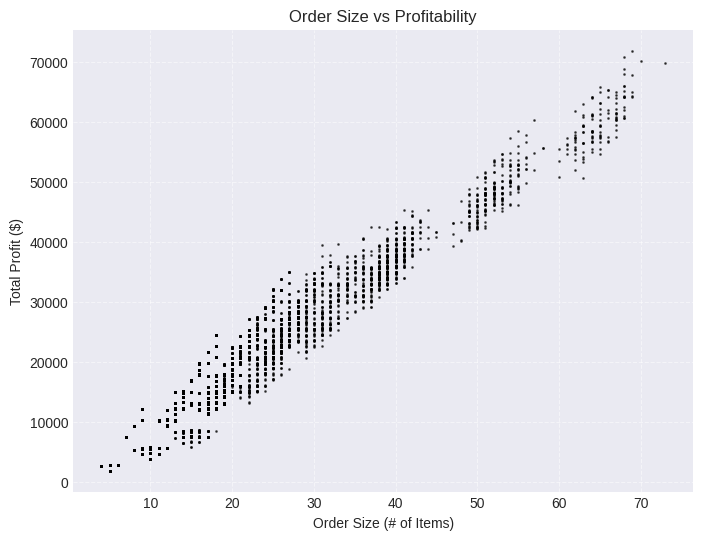

In [51]:
# Q5.3: Order size vs profitability
items_with_profit = (

    items

    .join(products, left_on="sku", right_on="sku")

    .join(supplies, left_on="sku", right_on="sku")

    .with_columns(

        (pl.col("price") - pl.col("cost")).alias("profit_per_unit")

    )

)



order_size_profitability = (

    items_with_profit

    .group_by("order_id")

    .agg([

        pl.count("id").alias("order_size"),

        pl.sum("profit_per_unit").alias("total_profit")

    ])

)

print("Order Size vs Profitability:")

print(order_size_profitability)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(
    order_size_profitability["order_size"],
    order_size_profitability["total_profit"],
    s=1,
    alpha=0.6,
    c="black"
)

plt.title("Order Size vs Profitability")
plt.xlabel("Order Size (# of Items)")
plt.ylabel("Total Profit ($)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [52]:
# Q5.4: Profitability by store
items_orders_stores = (

    items_with_profit

    .join(orders.select(["id", "store_id"]), left_on="order_id", right_on="id")

)



store_profitability = (

    items_orders_stores

    .group_by("store_id")

    .agg(pl.sum("profit_per_unit").alias("total_profit"))

    .join(stores.select(["id", "name"]), left_on="store_id", right_on="id")

    .sort("total_profit", descending=True)

)



print("Store Profitability:")

print(store_profitability)

Store Profitability:
shape: (2, 3)
┌─────────────────────────────────┬──────────────┬──────────────┐
│ store_id                        ┆ total_profit ┆ name         │
│ ---                             ┆ ---          ┆ ---          │
│ str                             ┆ i64          ┆ str          │
╞═════════════════════════════════╪══════════════╪══════════════╡
│ a9128331-08d7-41a2-b615-21283e… ┆ 239888460    ┆ Philadelphia │
│ a2a24e87-dec8-4f5d-9c9e-0e9849… ┆ 128076641    ┆ Brooklyn     │
└─────────────────────────────────┴──────────────┴──────────────┘


## Question 6: Business Optimization Recommendations

Based on your analysis, provide three specific, data-driven recommendations to improve business performance. Support each recommendation with relevant metrics and visualizations.

### Recommendation 1: Focus on Boosting Weekend Revenue

**Observation:** The analysis of revenue by day of the week (Question 1.4 and chart) clearly shows that Saturday and Sunday have significantly lower revenue compared to weekdays. There is a substantial opportunity to increase overall revenue by attracting more customers on weekends.

**Recommendation:** Implement targeted marketing campaigns and promotions specifically for weekends. This could include:
* Weekend-only discounts or special offers.
* Partnering with local events or businesses that are popular on weekends.
* Introducing limited-time weekend menu items with higher profit margins.

**Supporting Analysis:**
* **Metrics:** Compare weekend revenue before and after implementing promotions. Track the number of transactions and average order value on weekends.
* **Visualization:** Create a time series plot showing daily revenue with markers indicating promotion periods to visualize their impact.

### Recommendation 2: Leverage High-Margin Products

**Observation:** The profitability analysis (Question 5.2) identified products with the highest gross margins (e.g., 'flame impala', 'nutellaphone who dis?', 'mel-bun', and 'for richer or pourover'). Focusing on selling more of these items can directly increase overall profitability.

**Recommendation:** Promote high-margin products through various channels:
* Feature them prominently on the menu, both in-store and online.
* Train staff to upsell these items.
* Run promotions or create bundles that include high-margin products.

**Supporting Analysis:**
* **Metrics:** Track the sales volume and revenue contribution of high-margin products. Calculate the overall gross margin percentage and monitor its change.
* **Visualization:** Create a bar chart showing the gross margin for each product to visually highlight the high-margin items.

### Recommendation 3: Investigate Store Performance Discrepancies

**Observation:** The analysis of revenue per day since opening (Question 3.1) shows that the Brooklyn store has a higher revenue per day despite being open for a shorter period compared to the Philadelphia store. While the tax rate analysis (Question 3.2) with only two data points is inconclusive, there might be other factors contributing to the difference in performance.

**Recommendation:** Conduct a deeper investigation into the factors contributing to the Brooklyn store's higher revenue per day. This could involve:
* Analyzing customer demographics and local competition in both areas.
* Comparing operational efficiency, marketing efforts, and customer service between the stores.
* Reviewing local market trends and preferences.

**Supporting Analysis:**
* **Metrics:** Analyze customer acquisition cost and customer lifetime value by store. Compare sales volume and average order value by product category in each store.
* **Visualization:** Create a comparative dashboard showing key performance indicators (KPIs) for each store side-by-side.

## Executive Summary

This report presents a comprehensive data-driven analysis of Jaffle Shop's business performance, leveraging datasets on customers, orders, items, products, stores, and supplies using the Polars library. The analysis aimed to provide insights into revenue performance, product profitability, store expansion potential, and customer behavior to support strategic decision-making by the executive team, Product Manager, Operations Director, and Marketing Manager.

### Key Findings:

1.  **Significant Weekend Revenue Gap:** The analysis of daily revenue trends (Question 1.4) revealed a notable disparity, with Saturday and Sunday generating substantially lower revenue compared to weekdays. This indicates a considerable untapped potential to increase overall sales volume and revenue during the weekend period. For example, Saturday and Sunday combined generated approximately $12.2 million in revenue, while weekdays each generated over $10.6 million.

2.  **Identified High-Margin Product Opportunities:** The profitability analysis (Question 5.2) highlighted specific products with superior gross margins after accounting for supply costs. Products like 'flame impala', 'nutellaphone who dis?', 'mel-bun', and 'for richer or pourover' stand out as particularly profitable. Focusing efforts on increasing the sales of these items can directly lead to an improvement in the company's bottom line.

3.  **Variance in Store Performance Efficiency:** Evaluating revenue per day since opening (Question 3.1) showed that the Brooklyn store, despite being operational for a shorter duration (173 days) compared to the Philadelphia store (365 days), achieved a higher average revenue per day (approximately $131,922 vs.
$118,398). While the relationship between local tax rates and performance (Question 3.2) with only two stores was inconclusive, this difference in performance suggests that factors beyond tax rates may be at play, and understanding these could inform future expansion and operational strategies.

### Strategic Recommendations:

1.  **Implement Targeted Weekend Growth Initiatives:** To address the weekend revenue gap, Jaffle Shop should develop and execute targeted marketing campaigns and promotions specifically designed to attract customers on Saturdays and Sundays. This could involve offering weekend-specific discounts, creating limited-time special menu items with appealing margins, or partnering with local weekend events to drive foot traffic. The success of these initiatives should be measured by tracking weekend revenue growth, transaction volume, and average order value.

2.  **Prioritize and Promote High-Margin Products:** To enhance overall profitability, Jaffle Shop should strategically promote the identified high-margin products. This can be achieved by giving these items prominent placement on menus (physical and digital), training staff to actively recommend and upsell them, and incorporating them into attractive bundled offers. Monitoring the sales volume and revenue contribution of these products, as well as the overall gross margin percentage, will be crucial for evaluating the effectiveness of these efforts.

3.  **Conduct a Detailed Cross-Store Performance Study:** To capitalize on the observed higher revenue per day in the Brooklyn store, a detailed investigation is recommended to understand the contributing factors. This study should delve into local market characteristics, customer demographics, competitive landscapes, operational practices, marketing strategies, and customer service approaches in both the Brooklyn and Philadelphia locations. Identifying the key drivers of Brooklyn's higher performance can provide valuable insights and transferable best practices for improving performance in other existing stores and informing decisions for future store expansion locations and operational models. Key performance indicators (KPIs) such as customer acquisition cost, customer lifetime value, sales volume by product category, and average order value should be compared across stores as part of this investigation.

## Executive Summary

This report presents a comprehensive data-driven analysis of Jaffle Shop's business performance, leveraging datasets on customers, orders, items, products, stores, and supplies using the Polars library. The analysis aimed to provide insights into revenue performance, product profitability, store expansion potential, and customer behavior to support strategic decision-making by the executive team, Product Manager, Operations Director, and Marketing Manager.

### Key Findings:

1.  **Significant Weekend Revenue Gap:** The analysis of daily revenue trends (Question 1.4) revealed a notable disparity, with Saturday and Sunday generating substantially lower revenue compared to weekdays. This indicates a considerable untapped potential to increase overall sales volume and revenue during the weekend period. For example, Saturday and Sunday combined generated approximately \\$12.2 million in revenue, while weekdays each generated over \\$10.6 million.

2.  **Identified High-Margin Product Opportunities:** The profitability analysis (Question 5.2) highlighted specific products with superior gross margins after accounting for supply costs. Products like 'flame impala', 'nutellaphone who dis?', 'mel-bun', and 'for richer or pourover' stand out as particularly profitable. Focusing efforts on increasing the sales of these items can directly lead to an improvement in the company's bottom line.

3.  **Variance in Store Performance Efficiency:** Evaluating revenue per day since opening (Question 3.1) showed that the Brooklyn store, despite being operational for a shorter duration (173 days) compared to the Philadelphia store (365 days), achieved a higher average revenue per day (approximately \\$131,922 vs. \\$118,398). While the relationship between local tax rates and performance (Question 3.2) with only two stores was inconclusive, this difference in performance suggests that factors beyond tax rates may be at play, and understanding these could inform future expansion and operational strategies.

### Strategic Recommendations:

1.  **Implement Targeted Weekend Growth Initiatives:** To address the weekend revenue gap, Jaffle Shop should develop and execute targeted marketing campaigns and promotions specifically designed to attract customers on Saturdays and Sundays. This could involve offering weekend-specific discounts, creating limited-time special menu items with appealing margins, or partnering with local weekend events to drive foot traffic. The success of these initiatives should be measured by tracking weekend revenue growth, transaction volume, and average order value.

2.  **Prioritize and Promote High-Margin Products:** To enhance overall profitability, Jaffle Shop should strategically promote the identified high-margin products. This can be achieved by giving these items prominent placement on menus (physical and digital), training staff to actively recommend and upsell them, and incorporating them into attractive bundled offers. Monitoring the sales volume and revenue contribution of these products, as well as the overall gross margin percentage, will be crucial for evaluating the effectiveness of these efforts.

3.  **Conduct a Detailed Cross-Store Performance Study:** To capitalize on the observed higher revenue per day in the Brooklyn store, a detailed investigation is recommended to understand the contributing factors. This study should delve into local market characteristics, customer demographics, competitive landscapes, operational practices, marketing strategies, and customer service approaches in both the Brooklyn and Philadelphia locations. Identifying the key drivers of Brooklyn's higher performance can provide valuable insights and transferable best practices for improving performance in other existing stores and informing decisions for future store expansion locations and operational models. Key performance indicators (KPIs) such as customer acquisition cost, customer lifetime value, sales volume by product category, and average order value should be compared across stores as part of this investigation.